In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, Dropout
from tensorflow.keras.optimizers import Adam
from matplotlib import pyplot as plt
import itertools

In [2]:
from Forcasting_lib import load_fred_data
from Forcasting_lib import make_stationary
from Forcasting_lib import standardize_data

In [3]:
## load and transform data
df, transform_codes = load_fred_data()
df_stationary = make_stationary(df, transform_codes)

cols_to_standardize = [
    'GDPC1',      # Reales BIP
    'UNRATE',     # Arbeitslosenquote
    'FEDFUNDS',   # Federal Funds Rate
    'CPILFESL',   # Verbraucherpreisindex ohne Energie und Nahrungsmittel  #fehlt ein Wert 
    'PAYEMS',     # Beschäftigte außerhalb der Landwirtschaft
    'GS10',       # Rendite 10-jähriger Staatsanleihen
    'M2REAL',     # Reale Geldmenge M2
    'S&P 500'       # S&P 500 Index
]

df_std, scaler = standardize_data(df_stationary, cols_to_standardize)

data_scaled = df_std[cols_to_standardize].dropna().values

Datei 'current.csv' gefunden. Lade lokal...
Daten erfolgreich vorbereitet.
Standardisierung abgeschlossen.


## Kann nicht mit sklearn genutzt werden -> Expanding window selber implementieren 

In [ ]:
def evaluate_LSTM_forecaster(data_scaled, window_length=5, hidden_layer_sizes=32, initial_window=100):

    n_total = len(data_scaled)

    y_preds = []
    y_trues = []

    for i in range(initial_window, n_total - 1):
        train_data = data_scaled[:i]

        # Create sequences
        X_train, y_train = [], []
        for j in range(window_length, len(train_data)):
            X_train.append(train_data[j - window_length:j])
            y_train.append(train_data[j, 0])  # Zielvariable (GDPC1) 

        X_train = np.array(X_train)
        y_train = np.array(y_train)

        # Define LSTM model
        model = Sequential()
        model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
        model.add(LSTM(hidden_layer_sizes))
        model.add(Dense(1))
        model.compile(optimizer=Adam(learning_rate=0.01), loss='mse')

        # Train model
        model.fit(X_train, y_train, epochs=10, batch_size=16, verbose=0)

        # Predict next time step (i)
        x_input = data_scaled[i - window_length:i].reshape(1, window_length, data_scaled.shape[1])
        y_pred_scaled = model.predict(x_input, verbose=0)[0, 0]

        y_preds.append(y_pred_scaled)

        # True Value
        y_true_transformed = data_scaled[i, 0]  # GDPC1
        y_trues.append(y_true_transformed)
    rmse = np.sqrt(mean_squared_error(y_trues, y_preds))
    return rmse, y_preds, y_trues
    


In [7]:
rmse, y_preds, y_trues = evaluate_LSTM_forecaster(data_scaled[:150], initial_window=100, window_length=5)    

In [5]:
def evaluate_LSTM_MC_dropout(data_scaled, window_length=5, hidden_layer_sizes=32,
                              initial_window=150, dropout_rate=0.3, n_mc_samples=100):

    n_total = len(data_scaled)
    y_preds = []
    y_trues = []
    lower_bounds = []
    upper_bounds = []

    for i in range(initial_window, n_total - 1):
        # Prepare training data up to time i
        train_data = data_scaled[:i]

        X_train, y_train = [], []
        for j in range(window_length, len(train_data)):
            X_train.append(train_data[j - window_length:j])
            y_train.append(train_data[j, 0])  # target variable

        X_train = np.array(X_train)
        y_train = np.array(y_train)

        # Define LSTM model with Dropout
        model = Sequential([
            Input(shape=(X_train.shape[1], X_train.shape[2])),
            LSTM(hidden_layer_sizes, return_sequences=False),
            Dropout(dropout_rate),
            Dense(1)
        ])
        model.compile(optimizer=Adam(learning_rate=0.01), loss='mse')

        # Train model
        model.fit(X_train, y_train, epochs=10, batch_size=16, verbose=0)

        # Prepare input for prediction
        x_input = data_scaled[i - window_length:i].reshape(1, window_length, data_scaled.shape[1])

        # Monte Carlo Sampling
        preds_mc = []
        for _ in range(n_mc_samples):
            # Forward pass with dropout active
            y_pred = model(x_input, training=True).numpy().flatten()[0]
            preds_mc.append(y_pred)

        preds_mc = np.array(preds_mc)
        y_preds.append(preds_mc.mean())
        y_trues.append(data_scaled[i, 0])

        # 95% CI
        lower = np.percentile(preds_mc, 2.5)
        upper = np.percentile(preds_mc, 97.5)
        lower_bounds.append(lower)
        upper_bounds.append(upper)

    rmse = np.sqrt(mean_squared_error(y_trues, y_preds))
    return rmse, y_preds, y_trues, lower_bounds, upper_bounds


### Hyperparameteroptimierung mit Gridsearch

In [9]:
## erzeuge durch Iteration alle Kombinationen der Hyperparameter 
param_grid = {
    'window_length': [1, 2,3,5],
    'hidden_layer_sizes': [(16),(32), (64)],
}

param_grid = list(itertools.product(*param_grid.values()))

In [11]:
results = []
for window_length, hidden_layer_sizes in param_grid:
    rmse, y_trues, y_preds = evaluate_LSTM_forecaster(data_scaled[:150], 
                                                    initial_window=100, 
                                                    window_length=window_length, 
                                                    hidden_layer_sizes=hidden_layer_sizes)
    print(f"Params: window_length={window_length}, hidden_layer_sizes={hidden_layer_sizes}, RMSE: {rmse:.3f}")
    results.append(((window_length, hidden_layer_sizes), rmse))

Params: window_length=1, hidden_layer_sizes=16, RMSE: 0.519
Params: window_length=1, hidden_layer_sizes=32, RMSE: 0.526
Params: window_length=1, hidden_layer_sizes=64, RMSE: 0.525
Params: window_length=2, hidden_layer_sizes=16, RMSE: 0.508
Params: window_length=2, hidden_layer_sizes=32, RMSE: 0.516
Params: window_length=2, hidden_layer_sizes=64, RMSE: 0.536
Params: window_length=3, hidden_layer_sizes=16, RMSE: 0.527
Params: window_length=3, hidden_layer_sizes=32, RMSE: 0.537
Params: window_length=3, hidden_layer_sizes=64, RMSE: 0.537
Params: window_length=5, hidden_layer_sizes=16, RMSE: 0.521
Params: window_length=5, hidden_layer_sizes=32, RMSE: 0.562
Params: window_length=5, hidden_layer_sizes=64, RMSE: 0.549


In [16]:
best_params, best_rmse = min(results, key=lambda x: x[1])
print(f"Best parameter combination: window_length={best_params[0]}, hidden_layer_sizes={best_params[1]},  RMSE={best_rmse:.4f}")

Best parameter combination: window_length=2, hidden_layer_sizes=16,  RMSE=0.5083


Best parameter combination: window_length=2, hidden_layer_sizes=16,  RMSE=0.5083

### Final Prediction

In [44]:
rmse, y_preds, y_trues = evaluate_LSTM_forecaster(data_scaled, initial_window=150, window_length=best_params[0], hidden_layer_sizes=best_params[1])    

In [5]:
rmse, y_preds, y_trues = evaluate_LSTM_forecaster(data_scaled, initial_window=150, window_length=2, hidden_layer_sizes=16)    

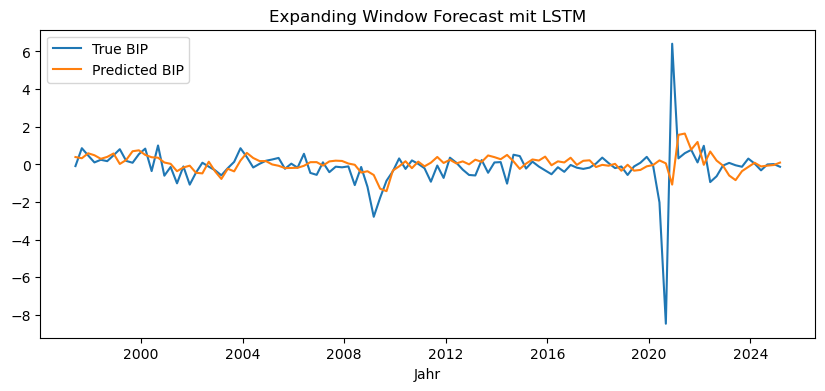

RMSE: 1.229


In [9]:
    # Auswertung
dates = df_std[cols_to_standardize].dropna().index[-len(y_preds):]  # Get the corresponding dates for the predictions
plt.figure(figsize=(10, 4))
plt.plot(dates, y_trues, label='True BIP')
plt.plot(dates, y_preds, label='Predicted BIP')
plt.xlabel("Jahr")
plt.legend()
plt.title("Expanding Window Forecast mit LSTM")
plt.savefig("./plots/final_forecast_RF.png")
plt.show()

rmse = np.sqrt(mean_squared_error(y_preds, y_trues))
print(f"RMSE: {rmse:.3f}")

In [10]:
# Speichern der Vorhersage- und True-Werte in einer CSV-Datei
results_df = pd.DataFrame({
    'date':  df_std.index[-len(y_preds):].tolist(),
    'y_true': y_trues,
    'y_pred': y_preds
})


results_df.to_csv('./Data/results/LSTM_forecast_results.csv', index=False)

### Prognose mit Konfidenzintervallen

In [6]:
rmse, y_preds, y_trues, lower_bounds, upper_bounds = evaluate_LSTM_MC_dropout(data_scaled, window_length=5, hidden_layer_sizes=32, initial_window=150, dropout_rate=0.3, n_mc_samples=100)

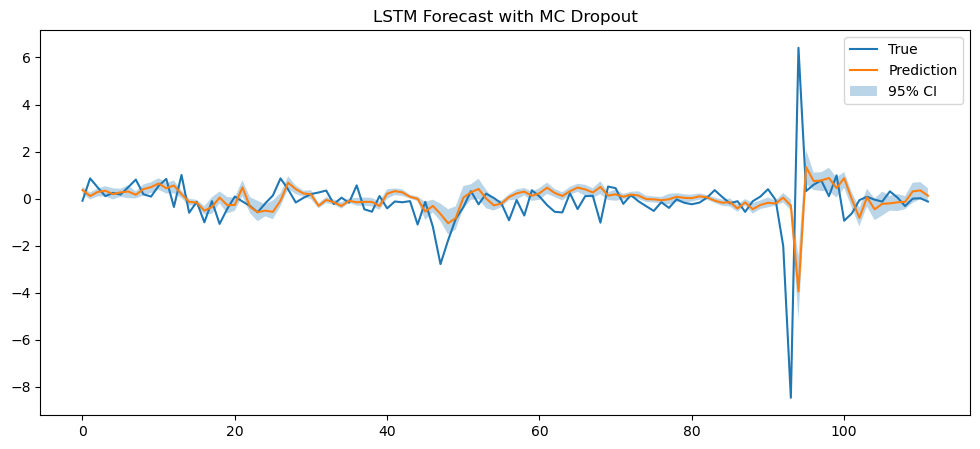

In [7]:
plt.figure(figsize=(12, 5))
plt.plot(y_trues, label="True")
plt.plot(y_preds, label="Prediction")
plt.fill_between(range(len(y_preds)), lower_bounds, upper_bounds, alpha=0.3, label="95% CI")
plt.title("LSTM Forecast with MC Dropout")
plt.legend()
plt.show()

In [8]:
# Speichern der Vorhersage- und True-Werte in einer CSV-Datei
results_df = pd.DataFrame({
    'date':  df_std.index[-len(y_preds):].tolist(),
    'y_true': y_trues,
    'y_pred': y_preds,
    'lower_bound': lower_bounds,
    'upper_bound': upper_bounds
})


results_df.to_csv('./Data/results/LSTM_forecast_results_CI.csv', index=False)

### Nutze Erweiteren Prädiktorensatz

In [9]:
cols_to_standardize = [
    'GDPC1',      # Reales BIP, Zielvariable
    'UNRATE',     # Arbeitslosenquote
    'FEDFUNDS',   # Federal Funds Rate
    'CPILFESL',   # Verbraucherpreisindex ohne Energie und Nahrungsmittel
    'PAYEMS',     # Beschäftigte außerhalb der Landwirtschaft
    'GS10',       # Rendite 10-jähriger Staatsanleihen
    'TB3MS',       # Rendite 3-monatiger Staatsanleihen
    'M2REAL',     # Reale Geldmenge M2
    'S&P 500',    # S&P 500 Index
    'PCECC96',    # PCE-Kerninflation
    'GPDIC1',     # Bruttoinlandsinvestitionen (real)
    'PNFIx',      # Private nichtwohnwirtschaftliche Investitionen
    'FPIx',       # Ausrüstungsinvestitionen
    'PCDGx',      # Konsum langlebiger Güter
    'PCNDx',      # Konsum nicht langlebiger Güter
    'PCESVx',     # Konsum von Dienstleistungen
    'CE16OV',     # Zivilbeschäftigung
    'CPIAUCSL',   # Verbraucherpreisindex (CPI)
    'PCEPILFE'    # PCE-Kerninflation
]


df_std, scaler = standardize_data(df_stationary, cols_to_standardize)

## Daten vorbereiten
data_scaled = df_std[cols_to_standardize].dropna().values

Standardisierung abgeschlossen.


In [8]:
rmse, y_preds, y_trues = evaluate_LSTM_forecaster(data_scaled, initial_window=150, window_length=2, hidden_layer_sizes=16)    

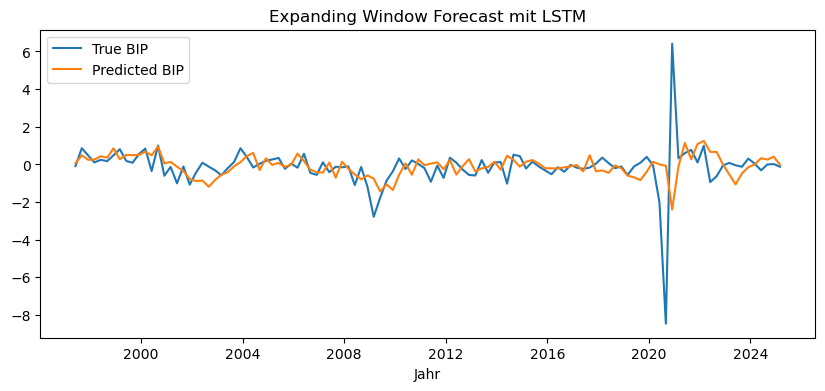

RMSE: 1.289


In [9]:
# Auswertung
dates = df_std[cols_to_standardize].dropna().index[-len(y_preds):]  # Get the corresponding dates for the predictions
plt.figure(figsize=(10, 4))
plt.plot(dates, y_trues, label='True BIP')
plt.plot(dates, y_preds, label='Predicted BIP')
plt.xlabel("Jahr")
plt.legend()
plt.title("Expanding Window Forecast mit LSTM")
#plt.savefig("./plots/final_forecast_2_RF.png")
plt.show()

rmse = np.sqrt(mean_squared_error(y_preds, y_trues))
print(f"RMSE: {rmse:.3f}")

In [10]:
# Speichern der Vorhersage- und True-Werte in einer CSV-Datei
results_df = pd.DataFrame({
    'date':  df_std.index[-len(y_preds):].tolist(),
    'y_true': y_trues,
    'y_pred': y_preds
})


results_df.to_csv('./Data/results/LSTM_forecast_2_results.csv', index=False)

## Erweitere Code um Konfidenzintervalle zu erhalten 

In [10]:
rmse, y_preds, y_trues, lower_bounds, upper_bounds = evaluate_LSTM_MC_dropout(data_scaled, window_length=5, hidden_layer_sizes=32, initial_window=150, dropout_rate=0.3, n_mc_samples=100)

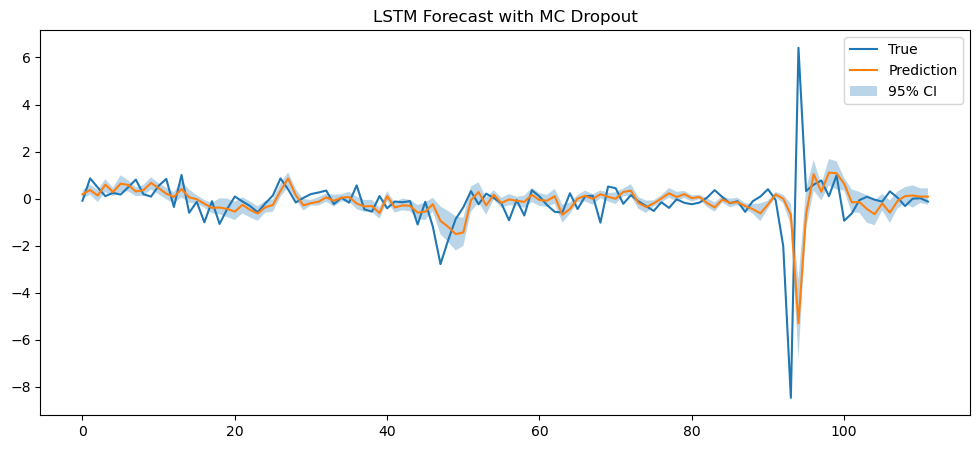

In [11]:
plt.figure(figsize=(12, 5))
plt.plot(y_trues, label="True")
plt.plot(y_preds, label="Prediction")
plt.fill_between(range(len(y_preds)), lower_bounds, upper_bounds, alpha=0.3, label="95% CI")
plt.title("LSTM Forecast with MC Dropout")
plt.legend()
plt.show()

In [12]:
# Speichern der Vorhersage- und True-Werte in einer CSV-Datei
results_df = pd.DataFrame({
    'date':  df_std.index[-len(y_preds):].tolist(),
    'y_true': y_trues,
    'y_pred': y_preds,
    'lower_bound': lower_bounds,
    'upper_bound': upper_bounds
})


results_df.to_csv('./Data/results/LSTM_forecast_results_CI_2.csv', index=False)